In [6]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

import csv

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from experiment_helpers.metrics import * 
from experiment_helpers.model_evaluation import * 
from src.solvers import *
from src.syntetic import *




In [4]:
def plot_error_results(ax, results, method):
    """Plot the accuracy comparison for a specific method on a given axis."""
    ax.set_title(f'Accuracy Comparison - {method}')
    ax.set_ylabel(method)
    ax.set_xlabel('Test Size')
    
  
    independent = [experiment['train_size'] for experiment in results]
    graph_accuracy = [experiment['graph_accuracy'] for experiment in results]
    hyper_graph_accuracy = [experiment['hyper_graph_accuracy'] for experiment in results]

    ax.plot(independent, graph_accuracy, label='Standard Graph Accuracy', marker='o')
    ax.plot(independent, hyper_graph_accuracy, label='Hyper-graph Accuracy', marker='s')

    ax.legend()
    # ax.grid(True)


def plot_all_error_results(results_dict):
    """Plot the error comparison for all methods in a single row."""
    methods = list(results_dict.keys())
    num_methods = len(methods)
    
    fig, axs = plt.subplots(1, num_methods, figsize=(6 * num_methods, 6))

    for i, method in enumerate(methods):
        plot_error_results(axs[i], results_dict[method], method)
    
    plt.tight_layout()
    plt.show()

def evaulate_training_sizes(N,M,K1,K2, loss_measurement ='rms', repetition = 5):

    all_results = []

    pi_values, data = generate_model_instance(N, M, K1, K2)

    for train_size in np.arange(0.1, 1.1, 0.1):
         
        std_bt_metrics = []
        ho_bt_metrics = []
        
        for _ in range(repetition):
            training_set, testing_set = split_games(data, train_size)

            hyper_graph_pred, graph_pred = compute_rankings(training_set=training_set, ground_truth_ratings=pi_values)

            ho_metrics.append( metric_evaluation(hyper_graph_pred, pi_values) )

        all_results.append({
            'loss_measurement': loss_measurement,
            'train_size': train_size,
            'N': N,
            'M': M,
            'K1': K1,
            'K2': K2,
            'graph_metrics': np.mean(graph_metrics),
            'hyper_graph_metrics': np.meand(hyper_graph_metrics)
        })

    return all_results


def metric_evaluation(predicted_ratings : dict[str:int], ground_truth_ratings: dict[str:int], loss_measurement: str) -> float:

    if loss_measurement == 'rms':
        return calculate_rms(predicted_ratings, ground_truth_ratings)
    elif loss_measurement == 'rho':
        return calculate_rho(predicted_ratings, ground_truth_ratings)
    elif loss_measurement == 'tau':
        return calculate_tau(predicted_ratings, ground_truth_ratings)
    else:
        return 0 

def run_all_metrics(M, N, K1, K2): 

    rms = test_training_size(N,M,K1,K2, loss_measurement ='rms')
    rho = test_training_size(N,M,K1,K2, loss_measurement = 'rho')
    tau = test_training_size(N,M,K1,K2, loss_measurement = 'tau')

    results_dict = {
        'rms': rms,
        'rho': rho,
        'tau': tau
    }

    plot_all_error_results(results_dict)
    
   

In [5]:
# Check dyadic hyperedges and standard graph produce the same results
run_all_metrics(250,750,2,2)


NameError: name 'test_training_size' is not defined

[{'loss_measurement': 'rms', 'train_size': 0.0, 'graph_accuracy': [1.7061686929360214], 'hyper_graph_accuracy': [1.7061686929360214]}, {'loss_measurement': 'rms', 'train_size': 0.1, 'graph_accuracy': [1.651157782120843], 'hyper_graph_accuracy': [1.652813785724772]}, {'loss_measurement': 'rms', 'train_size': 0.2, 'graph_accuracy': [1.6139011477269076], 'hyper_graph_accuracy': [1.6155704062908103]}, {'loss_measurement': 'rms', 'train_size': 0.30000000000000004, 'graph_accuracy': [1.5785556573187682], 'hyper_graph_accuracy': [1.5815404228650698]}, {'loss_measurement': 'rms', 'train_size': 0.4, 'graph_accuracy': [1.5455374159941528], 'hyper_graph_accuracy': [1.5478201756977312]}, {'loss_measurement': 'rms', 'train_size': 0.5, 'graph_accuracy': [1.47320418611731], 'hyper_graph_accuracy': [1.477133770356806]}, {'loss_measurement': 'rms', 'train_size': 0.6000000000000001, 'graph_accuracy': [1.435191728140281], 'hyper_graph_accuracy': [1.4410519215809425]}, {'loss_measurement': 'rms', 'train_s

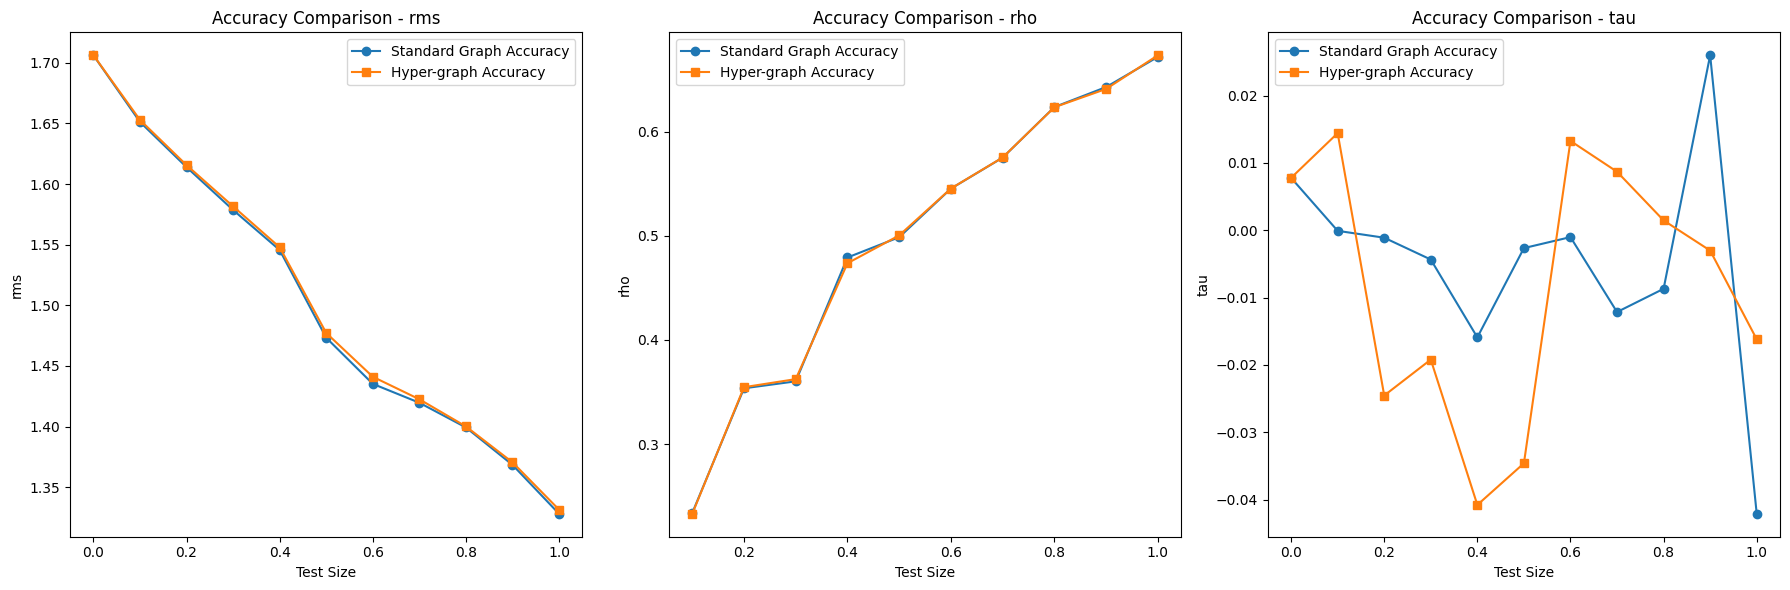

In [6]:
# Syntethic golf tournament example
run_all_metrics(1000,1500,2,4)


/home/jackyeung99/senior_thesis/higher_order_ranking/experiments/experiment_helpers/metrics.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_val = spearmanr(predicted_scores, true_scores)


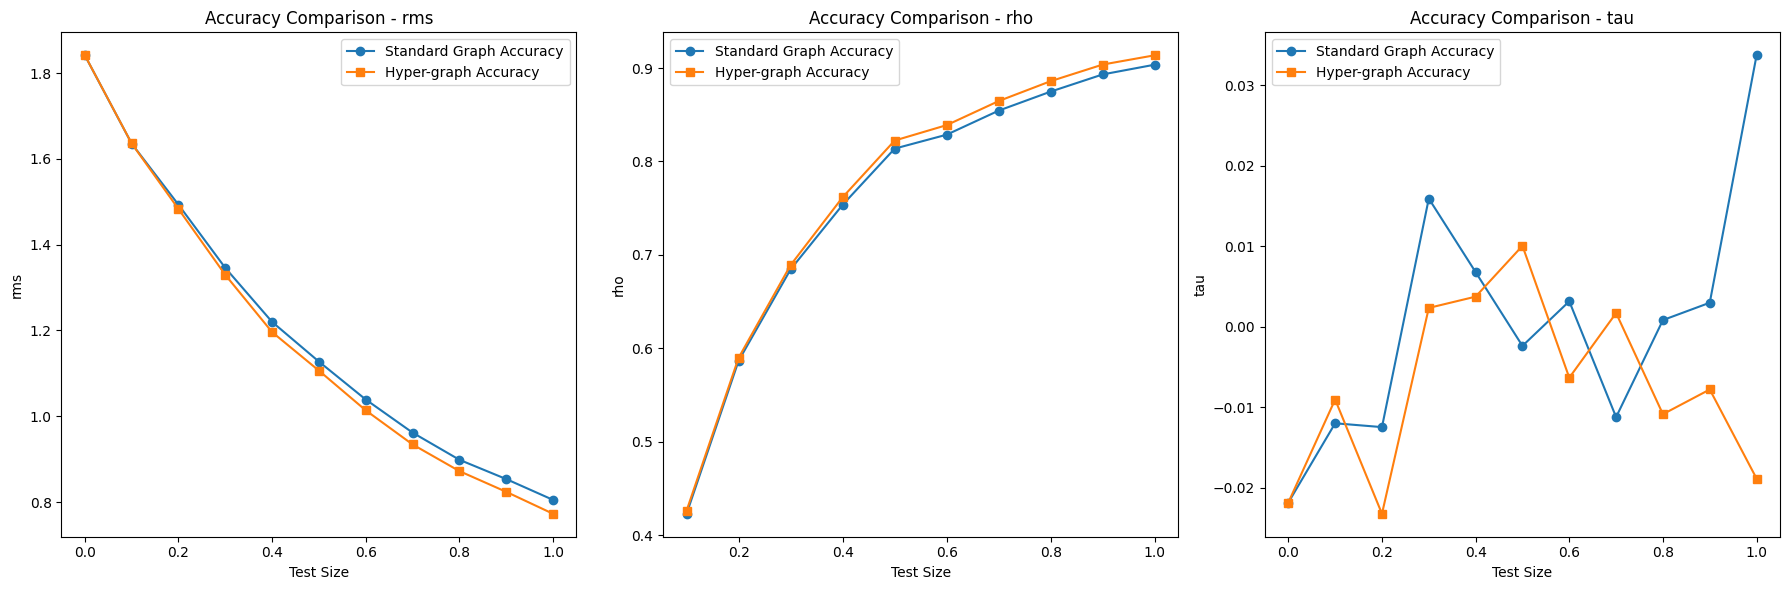

In [ ]:
# sample poker tournament
# stage one 
run_all_metrics(600,1200,9,10)

Model Differences through different ratios

In [12]:

def evaluate_model(N, M, K1, K2, repetitions=5):
    results = test_training_size(N, M, K1, K2, 'rms', repetitions)
    test_sizes = np.arange(0, 1.1, 0.1)
    graph_accuracies = np.array([res['graph_accuracy'] for res in results])
    hyper_graph_accuracies = np.array([res['hyper_graph_accuracy'] for res in results])
    return test_sizes, graph_accuracies, hyper_graph_accuracies


def compute_area_between_curves(x, y1, y2):
    area = np.trapz((y1 - y2), x)
    return area


def compute_areas_for_ratios(N, M_values, K1, K2, repetitions):
    ratios = []
    areas = []
    stds = []

    for M in M_values:
        area = []
        ratio = N / M
        ratios.append(ratio)
        for _ in range(repetitions):    
            _ , graph_acc, hyper_graph_acc = evaluate_model(N, M, K1, K2)
            area.append( compute_area_between_curves(np.arange(0, 1.1, 0.1), graph_acc, hyper_graph_acc))
            
        areas.append(np.mean(area))
        stds.append(np.std(area))

    return ratios, areas, stds


M_values = range(100, 2000, 50)

# Compute areas for different ratios of N and M
ratios, areas, stds = compute_areas_for_ratios(1000, M_values, K1=2, K2=4, repetitions=10)

[{'loss_measurement': 'rms', 'train_size': 0.0, 'N': 1000, 'M': 100, 'K1': 2, 'K2': 4, 'graph_accuracy': 1.7828159879955296, 'hyper_graph_accuracy': 1.7828159879955296}, {'loss_measurement': 'rms', 'train_size': 0.1, 'N': 1000, 'M': 100, 'K1': 2, 'K2': 4, 'graph_accuracy': 1.7743702755396267, 'hyper_graph_accuracy': 1.7743671786902835}, {'loss_measurement': 'rms', 'train_size': 0.2, 'N': 1000, 'M': 100, 'K1': 2, 'K2': 4, 'graph_accuracy': 1.7712466702909295, 'hyper_graph_accuracy': 1.7721743813503616}, {'loss_measurement': 'rms', 'train_size': 0.30000000000000004, 'N': 1000, 'M': 100, 'K1': 2, 'K2': 4, 'graph_accuracy': 1.7684573465159874, 'hyper_graph_accuracy': 1.7687818533838326}, {'loss_measurement': 'rms', 'train_size': 0.4, 'N': 1000, 'M': 100, 'K1': 2, 'K2': 4, 'graph_accuracy': 1.7520329210762535, 'hyper_graph_accuracy': 1.7529181049073008}, {'loss_measurement': 'rms', 'train_size': 0.5, 'N': 1000, 'M': 100, 'K1': 2, 'K2': 4, 'graph_accuracy': 1.7441027875643693, 'hyper_graph_a

KeyboardInterrupt: 

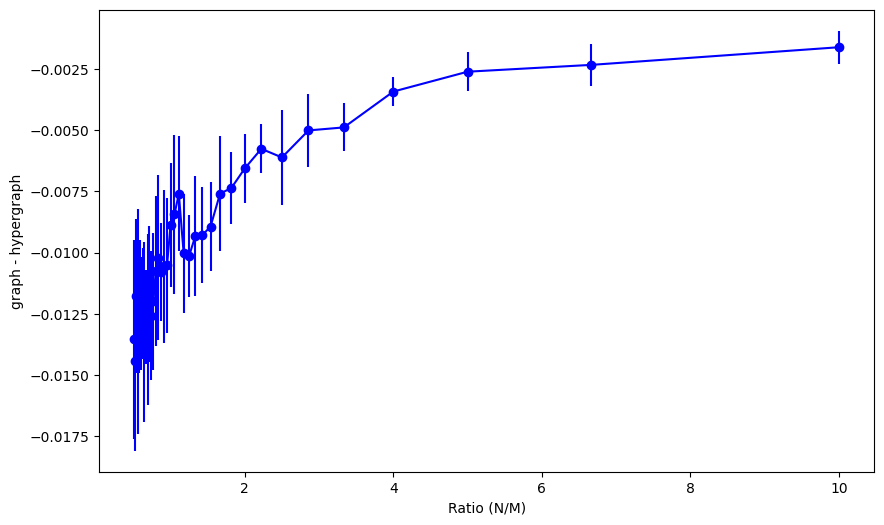

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.errorbar(ratios, areas, yerr=stds, c='blue', marker='o')
plt.xlabel('Ratio (N/M)')
plt.ylabel('graph - hypergraph')
# plt.xscale('log')
plt.show()